In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/Users/noelkonagai/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


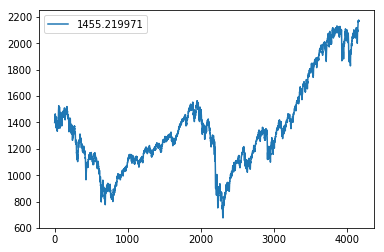

In [2]:
data = pd.read_csv('sp500.csv')
data.plot()

### Dividing the data into train and test

In [3]:
num_to_predict = 20

train_data = data[-100:-num_to_predict]
test_data = data[-num_to_predict:]

### Scaling the data

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [5]:
def next_batch(training_data,batch_size,steps):

    rand_start = np.random.randint(0, len(train_data) - steps)
    
    y_batch = np.array(training_data[rand_start : rand_start + steps + 1]).reshape(1, steps + 1)
    
    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [6]:
num_inputs = 1
num_time_steps = num_to_predict
num_neurons = 50
num_outputs = 1
lr = 0.01
num_inter_per_train = 2000
batch_size = 1

In [7]:
X = tf.placeholder(tf.float32, shape = [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, shape = [None, num_time_steps, num_inputs])

In [8]:
lstm_cell_1 = tf.contrib.rnn.LSTMCell(num_units = num_neurons, activation=tf.nn.relu)
lstm_cell_2 = tf.contrib.rnn.LSTMCell(num_units = num_neurons, activation=tf.nn.relu)
multi_lstm_cells = tf.contrib.rnn.MultiRNNCell(cells=[lstm_cell_1, lstm_cell_2] , state_is_tuple=True)


cell = tf.contrib.rnn.OutputProjectionWrapper(multi_lstm_cells, output_size = num_outputs)

In [9]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)

In [10]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = lr)
train = optimizer.minimize(loss)

In [11]:
init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.90)
saver = tf.train.Saver()

In [12]:
with tf.Session(config = tf.ConfigProto(gpu_options = gpu_options)) as sess:

    sess.run(init)
    
    for iteration in range(num_inter_per_train):
        
        X_batch, y_batch = next_batch(train_scaled, batch_size, num_time_steps)
        sess.run(train, feed_dict = {X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict = {X: X_batch, y: y_batch})
            print(iteration, "\tMSE ", mse) 
    
    
    # Save Model for Later
    saver.save(sess, "./stock_example_time_series")

0 	MSE  0.249462
100 	MSE  0.0167105
200 	MSE  0.0166318
300 	MSE  0.0143594
400 	MSE  0.037361
500 	MSE  0.0350291
600 	MSE  0.0103517
700 	MSE  0.00384293
800 	MSE  0.00618878
900 	MSE  0.00246098
1000 	MSE  0.00398398
1100 	MSE  0.00788179
1200 	MSE  0.00717944
1300 	MSE  0.00099428
1400 	MSE  0.00464632
1500 	MSE  0.0294872
1600 	MSE  0.00294483
1700 	MSE  0.00326762
1800 	MSE  0.00354408
1900 	MSE  0.0291371
2000 	MSE  0.0180348
2100 	MSE  0.0131445
2200 	MSE  0.00549566
2300 	MSE  0.00555113
2400 	MSE  0.00550447
2500 	MSE  0.00530902
2600 	MSE  0.00623962
2700 	MSE  0.0128209
2800 	MSE  0.00401998
2900 	MSE  0.00301708
3000 	MSE  0.00164692
3100 	MSE  0.00702843
3200 	MSE  0.0053463
3300 	MSE  0.00701722
3400 	MSE  0.00591177
3500 	MSE  0.00406766
3600 	MSE  0.00308935
3700 	MSE  0.00402663
3800 	MSE  0.00703097
3900 	MSE  0.00356853


In [13]:
with tf.Session() as sess:
    
    saver.restore(sess, "./stock_example_time_series")

    train_seed = list(train_scaled[-num_to_predict:])
    
    for iteration in range(num_to_predict):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict = {X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./stock_example_time_series


In [14]:
results = scaler.inverse_transform(np.array(train_seed[num_to_predict:]).reshape(num_to_predict,1))

In [15]:
result_data = test_data[:num_to_predict]
result_data['Generated'] = results

/Users/noelkonagai/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


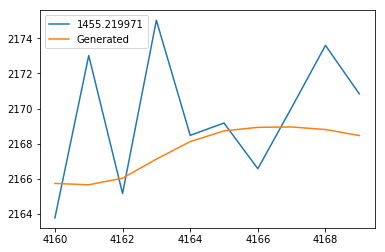

In [16]:
result_data.plot()